# GET CoV-19 POINT MUTATION FREQUENCY DATA 

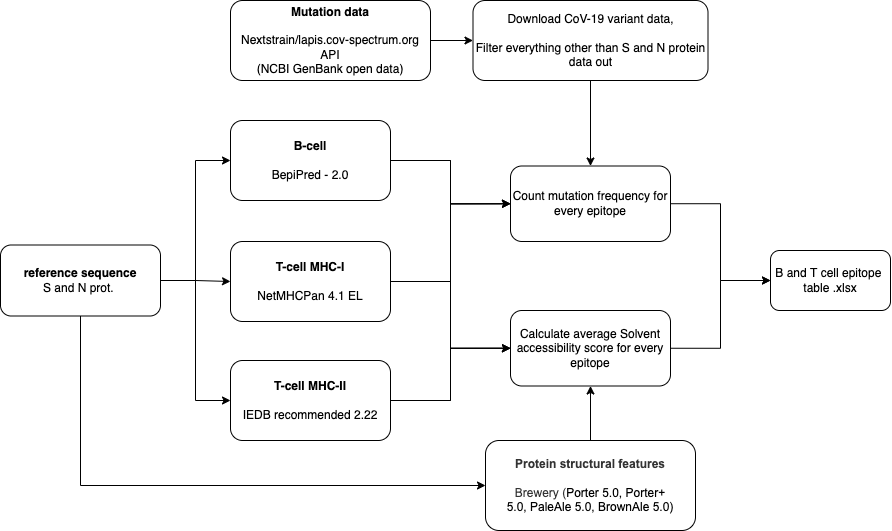

In [1]:
# show Workflow diagram
from IPython.display import Image, display
display(Image(filename='Diagrams/epitope_workflow.png', embed=True))

## Download CoV-19 mutation data from cov-spectrum


Muation variants selected from  https://covariants.org/variants

In [16]:
import requests

lineageList = {}

lineageList["alpha"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=B.1.1.7*").json()['data']
lineageList["beta"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=B.1.351*").json()['data']
lineageList["gamma"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=P.1*").json()['data']
lineageList["delta"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=B.1.617.2*").json()['data']

# omicron variants
lineageList["BA_1"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=BA.1*").json()['data']
lineageList["BA_2"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=BA.2").json()['data']
lineageList["BA_4"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=BA.4*").json()['data']
lineageList["BA_5"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=BA.5*").json()['data']
lineageList["BA_2_12_1"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=BA.2.12.1*").json()['data']
# B_1_1_529 is allegeadly BA_1 previos version https://viralzone.expasy.org/9556
lineageList["B_1_1_529"] = requests.get("https://lapis.cov-spectrum.org/open/v1/sample/aa-mutations?pangoLineage=B.1.1.529*").json()['data']

print(lineageList)

{'alpha': [{'mutation': 'ORF8:Q27*', 'proportion': 0.9944336377006179, 'count': 528091}, {'mutation': 'ORF8:R52I', 'proportion': 0.9933991719269667, 'count': 526887}, {'mutation': 'ORF8:Y73C', 'proportion': 0.9925886772293692, 'count': 527679}, {'mutation': 'ORF8:K68*', 'proportion': 0.3535552392592478, 'count': 182822}, {'mutation': 'S:N501Y', 'proportion': 0.9939657156005522, 'count': 518373}, {'mutation': 'S:D614G', 'proportion': 0.9953691440337104, 'count': 529834}, {'mutation': 'S:P681H', 'proportion': 0.9927050369446094, 'count': 528266}, {'mutation': 'S:H69-', 'proportion': 0.9932111585686266, 'count': 516002}, {'mutation': 'S:V70-', 'proportion': 0.9836372591693203, 'count': 515241}, {'mutation': 'S:Y144-', 'proportion': 0.9819994824996041, 'count': 508552}, {'mutation': 'S:A570D', 'proportion': 0.994142727046941, 'count': 528363}, {'mutation': 'S:T716I', 'proportion': 0.9932348786341404, 'count': 523109}, {'mutation': 'S:S982A', 'proportion': 0.994178334981034, 'count': 523929

In [17]:
# Description: from mutation definitions extract position and aa change values
# In: voc (json object)
# Out: DataFrame with added protein mutation position and aa substitition 
def extractMutationData(voc):
    position = []

    for aa in voc['mutation']:   
        change = aa[-1:]
        poz = aa[3:]
        poz=poz[:-1]
        position.append(poz)
        voc.loc[voc['mutation'] == aa, ['mutation']] = change
    
    voc.loc[:, ('position')] = position
    voc['position'] = pd.to_numeric(voc['position'])
    return voc

Combine all mutation data and their counts from JSON text to pandas dataFrame

In [18]:
import plotly.express
import pandas as pd

pd.set_option('mode.chained_assignment',None)

# proteinList['<VoC>']: 0 - s prot; 1 - n prot
proteinList = {}

for key in lineageList:

    voc = pd.DataFrame(lineageList[key],copy=False)

    # filter S un N protein data
    voc_N = voc[voc["mutation"].str.contains("N:")]
    voc_N = voc_N[voc_N["proportion"] < 0.95]
    voc_S = voc[voc["mutation"].str.contains("S:")]
    voc_S = voc_S[voc_S["proportion"] < 0.95]
       
    # print(voc_N)
    voc_N = extractMutationData(voc_N)
    # print(voc_N)

    fig = plotly.express.bar(voc_N, x="position", y="count", color="mutation", title=key+" AA substitutions N_Protein")
    fig.show()
    
    extractMutationData(voc_S)
    # print(voc_S)
    fig = plotly.express.bar(voc_S, x="position", y="count", color="mutation", title=key+" AA substitutions S_Protein")
    fig.show()

    # add S, N  prot to VoC list
    proteinList[key] = [voc_S, voc_N]



In [48]:
# access protein mutation list example

# S protein mutations
print(proteinList["gamma"][0])

# N preotein mutations
print(proteinList["gamma"][1])

  mutation  proportion  count  position
7        V    0.052154   1321       688
Empty DataFrame
Columns: [mutation, proportion, count, position]
Index: []


# Find best epitopes from predicted T-cell and B-cell epitope lists

Define functions that assign mutation frequency to epitope and burried state score to table.

In [29]:
import statistics

# epitopeList - dataFrame with epitopes, their positions and  result fields
# lineage: variants of concern from Protein list. for example "alpha", "beta", "gamma",  "BA_1", "BA_2_12_1" and others  
# protein (0 or 1): 0 - S, 1 - N
def countMutations(epitopeList, lineage, protein):
    
    if (protein!=0 and protein!=1):
        print("protein parameter acceptable values are for S prot - 0 N prot - 1 ")
        return
    
    # count mutations
    for i in range(len(epitopeList)):
           
        # counter to tell how many mutations was in epitope
        mututationFrequency = 0
        # list to store mutation count for finding median
        epitopeMutationList = []  
        # For every mutation in CoV variant
        for j in range(len(proteinList[lineage][protein])):
            
            if epitopeList.loc[i]['start'] <= proteinList[lineage][protein].iloc[j]['position'] <= epitopeList.loc[i]['end']:
                epitopeList.loc[i, 'mutation count'] += proteinList[lineage][protein].iloc[j]['count']
                epitopeMutationList.append(proteinList[lineage][protein].iloc[j]['count'])
                epitopeList.loc[i, 'mutation proportion'] += proteinList[lineage][protein].iloc[j]['proportion']
                mututationFrequency += 1

        # avarage proportion of mutations
        if (mututationFrequency == 0):
            epitopeList.loc[i, 'mutation proportion'] = 0
        elif(mututationFrequency > 0):
            epitopeList.loc[i, 'mutation proportion'] = epitopeList.loc[i, 'mutation proportion'] / mututationFrequency
        
        # Find median to tell 
        if (epitopeMutationList == []):
            epitopeList.loc[i, 'mutation median'] = 0
        else:
            epitopeList.loc[i, 'mutation median'] = statistics.median(epitopeMutationList)
                

In [30]:
# Calculate avarage Solvent Accsesibility (SA) score
def countBurriedStates(peptideList, variant, protein_struct):
    for peptide in range(len(peptideList)):
        for positionInSequence in range(peptideList.loc[peptide]['start'], peptideList.loc[peptide]['end']+1):
            # print(peptide, positionInSequence, protein_struct[variant]['SEQ'].loc[0][positionInSequence-1], protein_struct[variant]['SA'].loc[0][positionInSequence-1], protein_struct[variant]['SA_confidence'].loc[0][positionInSequence-1])
            if (protein_struct[variant]['SA'].loc[0][positionInSequence-1] == 'B'):
                peptideList.loc[peptide,'accessibility score'] += 0
            elif (protein_struct[variant]['SA'].loc[0][positionInSequence-1] == 'b'):
                peptideList.loc[peptide,'accessibility score'] += 1
            elif (protein_struct[variant]['SA'].loc[0][positionInSequence-1] == 'e'):
                peptideList.loc[peptide,'accessibility score'] += 2
            elif (protein_struct[variant]['SA'].loc[0][positionInSequence-1] == 'E'):
                peptideList.loc[peptide,'accessibility score'] += 3
            else:
                print("Error: in countBurriedStates() Relative Solvent Accessibility prediction ('E','e','b','B') not found in *solvent_accesibility_*.json table")
            peptideList.loc[peptide,'accessibility confidence'] += int(protein_struct[variant]['SA_confidence'].loc[0][positionInSequence-1])

        # add calculated score to peptide table
        peptideList.loc[peptide,'accessibility score'] = peptideList.loc[peptide,'accessibility score'] / peptideList.loc[peptide]['length']
        peptideList.loc[peptide,'accessibility confidence'] = peptideList.loc[peptide,'accessibility confidence'] / peptideList.loc[peptide]['length']

## Spike protein

In [31]:
import pandas as pd

# load predicted structure of burried and exposed aa residues
S_protein = 0
spike_Struct = {}
# spike_Struct["wuhan"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_wuhan.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["BA_1"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_BA_1.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["BA_2_12_1"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_BA_2_12_1.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["BA_2"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_BA_2.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["BA_4"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_BA_4.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["BA_5"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_BA_5.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["alpha"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_alpha.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["beta"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_beta.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["delta"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_delta.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
spike_Struct["gamma"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_gamma.json", dtype=pd.StringDtype(), orient='values', typ ='frame')


In [32]:
# Struct access example
print(spike_Struct["beta"]['SEQ'])

0    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
Name: SEQ, dtype: object


In [33]:
bCell_list_N["alpha"].loc[0]

No.                                                                     1
start                                                                   4
end                                                                    48
Peptide                     NGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNN
Length                                                                 45
mutation count                                                          0
mutation proportion                                                   0.0
mutation median                                                         0
accessibility score                                                   3.0
accessibility confidence                                         4.888889
Name: 0, dtype: object

### B-cell epitopes

predicted with BepiPred-2.0 (http://tools.iedb.org/bcell/) from Wuhan reference sequence

In [34]:
# Create dictionary from CoV-19 lineage predicted epitope csv files   

bCell_list = {}
# bCell_list["wuhan"] = pd.read_csv("sProt/data/B-cell/wuhan.csv", sep=";")
bCell_list["alpha"] = pd.read_csv("sProt/data/B-cell/alpha.csv", sep=";")
bCell_list["beta"] = pd.read_csv("sProt/data/B-cell/beta.csv", sep=";")
bCell_list["delta"] = pd.read_csv("sProt/data/B-cell/delta.csv", sep=";")
bCell_list["gamma"] = pd.read_csv("sProt/data/B-cell/gamma.csv", sep=";")
bCell_list["BA_1"] = pd.read_csv("sProt/data/B-cell/BA_1.csv", sep=";")
bCell_list["BA_2_12_1"] = pd.read_csv("sProt/data/B-cell/BA_2_12_1.csv", sep=";")
bCell_list["BA_2"] = pd.read_csv("sProt/data/B-cell/BA_2.csv", sep=";")
bCell_list["BA_4"] = pd.read_csv("sProt/data/B-cell/BA_4.csv", sep=";")
bCell_list["BA_5"] = pd.read_csv("sProt/data/B-cell/BA_5.csv", sep=";")

In [35]:
for variant in bCell_list:
    # change column names so they would match other cell type tables
    bCell_list[variant].rename(columns = {'Start':'start', 'End':'end', 'Length':'length'}, inplace = True)

    # add column for mutation frequency
    bCell_list[variant].loc[:,'mutation count'] = 0
    bCell_list[variant].loc[:,'mutation proportion'] = 0
    bCell_list[variant].loc[:,'mutation median'] = 0
    bCell_list[variant].loc[:,'accessibility score'] = 0
    bCell_list[variant].loc[:,'accessibility confidence'] = 0

    print("Count ", variant, " mutations")
    countMutations(bCell_list[variant], variant, S_protein)
    print("Count ", variant, " burried states")            
    countBurriedStates(bCell_list[variant], variant, spike_Struct)

Count  alpha  mutations
Count  alpha  burried states
Count  beta  mutations
Count  beta  burried states
Count  delta  mutations
Count  delta  burried states
Count  gamma  mutations
Count  gamma  burried states
Count  BA_1  mutations
Count  BA_1  burried states
Count  BA_2_12_1  mutations
Count  BA_2_12_1  burried states
Count  BA_2  mutations
Count  BA_2  burried states
Count  BA_4  mutations
Count  BA_4  burried states
Count  BA_5  mutations
Count  BA_5  burried states


### T-cell MHC-1 allele epitopes

For epitope prediction IEDB recommended 2020.09 (NetMHCPan 4.1 EL) (http://tools.iedb.org/mhci/) was used. All human HLA allele reference set was selected, 

In [36]:
mhc_1_List = {}
# mhc_1_List['wuhan'] = pd.read_csv("sProt/data/MHC-I/wuhan.csv", sep=";")
mhc_1_List['alpha'] = pd.read_csv("sProt/data/MHC-I/alpha.csv", sep=";")
mhc_1_List['beta'] = pd.read_csv("sProt/data/MHC-I/beta.csv", sep=";")
mhc_1_List['delta'] = pd.read_csv("sProt/data/MHC-I/delta.csv", sep=";")
mhc_1_List['gamma'] = pd.read_csv("sProt/data/MHC-I/gamma.csv", sep=";")
mhc_1_List['BA_1'] = pd.read_csv("sProt/data/MHC-I/BA_1.csv", sep=";")
mhc_1_List['BA_2_12_1'] = pd.read_csv("sProt/data/MHC-I/BA_2_12_1.csv", sep=";")
mhc_1_List['BA_2'] = pd.read_csv("sProt/data/MHC-I/BA_2.csv", sep=";")
mhc_1_List['BA_4'] = pd.read_csv("sProt/data/MHC-I/BA_4.csv", sep=";")
mhc_1_List['BA_5'] = pd.read_csv("sProt/data/MHC-I/BA_5.csv", sep=";")

In [37]:
for variant in mhc_1_List:
    print("Processing variant: ", variant)
    # flter sequnces with predicted rank score larger than 50%
    mhc_1_List[variant] = mhc_1_List[variant].loc[ mhc_1_List[variant]['score'] > 0.01]
    mhc_1_List[variant] = mhc_1_List[variant].reset_index(drop=True)

    mhc_1_List[variant].loc[:,'mutation count'] = 0
    mhc_1_List[variant].loc[:,'mutation proportion'] = 0
    mhc_1_List[variant].loc[:,'mutation median'] = 0
    mhc_1_List[variant].loc[:,'accessibility score'] = 0
    mhc_1_List[variant].loc[:,'accessibility confidence'] = 0
    
    print("Count ", variant, " mutations")
    countMutations(mhc_1_List[variant], variant, S_protein)
    print("Count ", variant, " burried states")        
    countBurriedStates(mhc_1_List[variant], variant, spike_Struct)



Processing variant:  alpha
Count  alpha  mutations
Count  alpha  burried states
Processing variant:  beta
Count  beta  mutations
Count  beta  burried states
Processing variant:  delta
Count  delta  mutations
Count  delta  burried states
Processing variant:  gamma
Count  gamma  mutations
Count  gamma  burried states
Processing variant:  BA_1
Count  BA_1  mutations
Count  BA_1  burried states
Processing variant:  BA_2_12_1
Count  BA_2_12_1  mutations
Count  BA_2_12_1  burried states
Processing variant:  BA_2
Count  BA_2  mutations
Count  BA_2  burried states
Processing variant:  BA_4
Count  BA_4  mutations
Count  BA_4  burried states
Processing variant:  BA_5
Count  BA_5  mutations
Count  BA_5  burried states


### T-cell MHC-2 allele epitopes

For epitope prediction IEDB recommended 2.22 (http://tools.iedb.org/mhcii/) was used. Full HLA reference set was selected wirh defaul length (i guess 15). Select species/locus: Human, HLA-DR 

In [38]:
# Read predicted epitopes for T-cell MHC-2 allele 
mhc_2_List = {}
# mhc_2_List['wuhan'] = pd.read_csv("sProt/data/MHC-I/wuhan.csv", sep=";")
mhc_2_List['alpha'] = pd.read_csv("sProt/data/MHC-II/alpha.csv", sep=";")
mhc_2_List['beta'] = pd.read_csv("sProt/data/MHC-II/beta.csv", sep=";")
mhc_2_List['delta'] = pd.read_csv("sProt/data/MHC-II/delta.csv", sep=";")
mhc_2_List['gamma'] = pd.read_csv("sProt/data/MHC-II/gamma.csv", sep=";")
mhc_2_List['BA_1'] = pd.read_csv("sProt/data/MHC-II/BA_1.csv", sep=";")
mhc_2_List['BA_2_12_1'] = pd.read_csv("sProt/data/MHC-II/BA_2_12_1.csv", sep=";")
mhc_2_List['BA_2'] = pd.read_csv("sProt/data/MHC-II/BA_2.csv", sep=";")
mhc_2_List['BA_4'] = pd.read_csv("sProt/data/MHC-II/BA_4.csv", sep=";")
mhc_2_List['BA_5'] = pd.read_csv("sProt/data/MHC-II/BA_5.csv", sep=";")

In [39]:
for variant in mhc_2_List:
    print("Processing variant: ", variant)
    # add result columns
    mhc_2_List[variant].loc[:,'mutation count'] = 0
    mhc_2_List[variant].loc[:,'mutation proportion'] = 0
    mhc_2_List[variant].loc[:,'mutation median'] = 0
    mhc_2_List[variant].loc[:,'accessibility score'] = 0
    mhc_2_List[variant].loc[:,'accessibility confidence'] = 0

    # filter low rank epitopes
    mhc_2_List[variant] = mhc_2_List[variant].loc[mhc_2_List[variant]['percentile_rank'] > 0.5]
    mhc_2_List[variant] = mhc_2_List[variant].reset_index(drop=True)

    print("Count ", variant, " mutations")
    countMutations(mhc_2_List[variant], variant, S_protein)
    print("Count ", variant, " burried states")
    countBurriedStates(mhc_2_List[variant], variant, spike_Struct)

Processing variant:  alpha
Count  alpha  mutations
Count  alpha  burried states
Processing variant:  beta
Count  beta  mutations
Count  beta  burried states
Processing variant:  delta
Count  delta  mutations
Count  delta  burried states
Processing variant:  gamma
Count  gamma  mutations
Count  gamma  burried states
Processing variant:  BA_1
Count  BA_1  mutations
Count  BA_1  burried states
Processing variant:  BA_2_12_1
Count  BA_2_12_1  mutations
Count  BA_2_12_1  burried states
Processing variant:  BA_2
Count  BA_2  mutations
Count  BA_2  burried states
Processing variant:  BA_4
Count  BA_4  mutations
Count  BA_4  burried states
Processing variant:  BA_5
Count  BA_5  mutations
Count  BA_5  burried states


In [40]:
# write result tabels to excel files
# print(fileName)
for variant in mhc_2_List:
    fileName = "sProt/S_epitope_" + variant + ".xlsx"
    with pd.ExcelWriter(fileName) as writer: 
        bCell_list[variant].to_excel(writer, sheet_name='B-cell')
        mhc_1_List[variant].to_excel(writer, sheet_name='MHC-I t-cell')
        mhc_2_List[variant].to_excel(writer, sheet_name='MHC-II t-cell')  
    
    print(variant, " epitope list saved at ", fileName)

alpha  epitope list saved at  sProt/S_epitope_alpha.xlsx
beta  epitope list saved at  sProt/S_epitope_beta.xlsx
delta  epitope list saved at  sProt/S_epitope_delta.xlsx
gamma  epitope list saved at  sProt/S_epitope_gamma.xlsx
BA_1  epitope list saved at  sProt/S_epitope_BA_1.xlsx
BA_2_12_1  epitope list saved at  sProt/S_epitope_BA_2_12_1.xlsx
BA_2  epitope list saved at  sProt/S_epitope_BA_2.xlsx
BA_4  epitope list saved at  sProt/S_epitope_BA_4.xlsx
BA_5  epitope list saved at  sProt/S_epitope_BA_5.xlsx


## N protein

In [41]:
N_protein = 1
# load predicted structure of burried and exposed aa residues
N_Struct = {}
# spike_Struct["wuhan"] = pd.read_json("sProt/data/struct/s_protein_structural_annotations_wuhan.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["BA_1"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_BA_1.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["BA_2_12_1"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_BA_2_12_1.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["BA_2"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_BA_2.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["BA_4"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_BA_4.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["BA_5"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_BA_5.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["alpha"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_alpha.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["beta"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_beta.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["delta"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_delta.json", dtype=pd.StringDtype(), orient='values', typ ='frame')
N_Struct["gamma"] = pd.read_json("nProt/data/struct/n_protein_structural_annotations_gamma.json", dtype=pd.StringDtype(), orient='values', typ ='frame')


### B-cell epitopes

predicted with BepiPred-2.0 (http://tools.iedb.org/bcell/) from Wuhan reference sequence

In [42]:
# Create dictionary from CoV-19 lineage predicted epitope csv files   

bCell_list_N = {}
# bCell_list_N["wuhan"] = pd.read_csv("nProt/data/B-cell/wuhan.csv", sep=";")
bCell_list_N["alpha"] = pd.read_csv("nProt/data/B-cell/alpha.csv", sep=";")
bCell_list_N["beta"] = pd.read_csv("nProt/data/B-cell/beta.csv", sep=";")
bCell_list_N["delta"] = pd.read_csv("nProt/data/B-cell/delta.csv", sep=";")
bCell_list_N["gamma"] = pd.read_csv("nProt/data/B-cell/gamma.csv", sep=";")
bCell_list_N["BA_1"] = pd.read_csv("nProt/data/B-cell/BA_1.csv", sep=";")
bCell_list_N["BA_2_12_1"] = pd.read_csv("nProt/data/B-cell/BA_2_12_1.csv", sep=";")
bCell_list_N["BA_2"] = pd.read_csv("nProt/data/B-cell/BA_2.csv", sep=";")
bCell_list_N["BA_4"] = pd.read_csv("nProt/data/B-cell/BA_4.csv", sep=";")
bCell_list_N["BA_5"] = pd.read_csv("nProt/data/B-cell/BA_5.csv", sep=";")

for variant in bCell_list_N:
    # change column names so they would match other cell type tables
    bCell_list_N[variant].rename(columns = {'Start':'start', 'End':'end', 'Length':'length'}, inplace = True)

    # add column for mutation frequency
    bCell_list_N[variant].loc[:,'mutation count'] = 0
    bCell_list_N[variant].loc[:,'mutation proportion'] = 0
    bCell_list_N[variant].loc[:,'mutation median'] = 0
    bCell_list_N[variant].loc[:,'accessibility score'] = 0
    bCell_list_N[variant].loc[:,'accessibility confidence'] = 0

    print("Count ", variant, " mutations")
    countMutations(bCell_list_N[variant], variant, N_protein)
    print("Count ", variant, " burried states")            
    countBurriedStates(bCell_list_N[variant], variant, N_Struct)

Count  alpha  mutations
Count  alpha  burried states
Count  beta  mutations
Count  beta  burried states
Count  delta  mutations
Count  delta  burried states
Count  gamma  mutations
Count  gamma  burried states
Count  BA_1  mutations
Count  BA_1  burried states
Count  BA_2_12_1  mutations
Count  BA_2_12_1  burried states
Count  BA_2  mutations
Count  BA_2  burried states
Count  BA_4  mutations
Count  BA_4  burried states
Count  BA_5  mutations
Count  BA_5  burried states


### T-cell MHC-1 allele epitopes

For epitope prediction IEDB recommended 2020.09 (NetMHCPan 4.1 EL) (http://tools.iedb.org/mhci/) was used. All human HLA allele reference set was selected, 

In [43]:
mhc_1_List_N = {}
# mhc_1_List_N['wuhan'] = pd.read_csv("nProt/data/MHC-I/wuhan.csv", sep=";")
mhc_1_List_N['alpha'] = pd.read_csv("nProt/data/MHC-I/alpha.csv", sep=";")
mhc_1_List_N['beta'] = pd.read_csv("nProt/data/MHC-I/beta.csv", sep=";")
mhc_1_List_N['delta'] = pd.read_csv("nProt/data/MHC-I/delta.csv", sep=";")
mhc_1_List_N['gamma'] = pd.read_csv("nProt/data/MHC-I/gamma.csv", sep=";")
mhc_1_List_N['BA_1'] = pd.read_csv("nProt/data/MHC-I/BA_1.csv", sep=";")
mhc_1_List_N['BA_2_12_1'] = pd.read_csv("nProt/data/MHC-I/BA_2_12_1.csv", sep=";")
mhc_1_List_N['BA_2'] = pd.read_csv("nProt/data/MHC-I/BA_2.csv", sep=";")
mhc_1_List_N['BA_4'] = pd.read_csv("nProt/data/MHC-I/BA_4.csv", sep=";")
mhc_1_List_N['BA_5'] = pd.read_csv("nProt/data/MHC-I/BA_5.csv", sep=";")


In [44]:
for variant in mhc_1_List_N:
    print("Processing variant: ", variant)
    # flter sequnces with predicted rank score larger than 50%
    mhc_1_List_N[variant] = mhc_1_List_N[variant].loc[ mhc_1_List_N[variant]['score'] > 0.01]
    mhc_1_List_N[variant] = mhc_1_List_N[variant].reset_index(drop=True)

    mhc_1_List_N[variant].loc[:,'mutation count'] = 0
    mhc_1_List_N[variant].loc[:,'mutation proportion'] = 0
    mhc_1_List_N[variant].loc[:,'mutation median'] = 0
    mhc_1_List_N[variant].loc[:,'accessibility score'] = 0
    mhc_1_List_N[variant].loc[:,'accessibility confidence'] = 0
    
    print("Count ", variant, " mutations")
    countMutations(mhc_1_List_N[variant], variant, N_protein)
    print("Count ", variant, " burried states")        
    countBurriedStates(mhc_1_List_N[variant], variant, N_Struct)

Processing variant:  alpha
Count  alpha  mutations
Count  alpha  burried states
Processing variant:  beta
Count  beta  mutations
Count  beta  burried states
Processing variant:  delta
Count  delta  mutations
Count  delta  burried states
Processing variant:  gamma
Count  gamma  mutations
Count  gamma  burried states
Processing variant:  BA_1
Count  BA_1  mutations
Count  BA_1  burried states
Processing variant:  BA_2_12_1
Count  BA_2_12_1  mutations
Count  BA_2_12_1  burried states
Processing variant:  BA_2
Count  BA_2  mutations
Count  BA_2  burried states
Processing variant:  BA_4
Count  BA_4  mutations
Count  BA_4  burried states
Processing variant:  BA_5
Count  BA_5  mutations
Count  BA_5  burried states


### T-cell MHC-2 allele epitopes

For epitope prediction IEDB recommended 2.22 (http://tools.iedb.org/mhcii/) was used. Full HLA reference set was selected wirh defaul length (i guess 15). Select species/locus: Human, HLA-DR 

In [45]:
# Read predicted epitopes for T-cell MHC-2 allele 
mhc_2_List_N = {}
# mhc_2_List['wuhan'] = pd.read_csv("nProt/data/MHC-I/wuhan.csv", sep=";")
mhc_2_List_N['alpha'] = pd.read_csv("nProt/data/MHC-II/alpha.csv", sep=";")
mhc_2_List_N['beta'] = pd.read_csv("nProt/data/MHC-II/beta.csv", sep=";")
mhc_2_List_N['delta'] = pd.read_csv("nProt/data/MHC-II/delta.csv", sep=";")
mhc_2_List_N['gamma'] = pd.read_csv("nProt/data/MHC-II/gamma.csv", sep=";")
mhc_2_List_N['BA_1'] = pd.read_csv("nProt/data/MHC-II/BA_1.csv", sep=";")
mhc_2_List_N['BA_2_12_1'] = pd.read_csv("nProt/data/MHC-II/BA_2_12_1.csv", sep=";")
mhc_2_List_N['BA_2'] = pd.read_csv("nProt/data/MHC-II/BA_2.csv", sep=";")
mhc_2_List_N['BA_4'] = pd.read_csv("nProt/data/MHC-II/BA_4.csv", sep=";")
mhc_2_List_N['BA_5'] = pd.read_csv("nProt/data/MHC-II/BA_5.csv", sep=";")

In [46]:
for variant in mhc_2_List_N:
    print("Processing variant: ", variant)
    # add result columns
    mhc_2_List_N[variant].loc[:,'mutation count'] = 0
    mhc_2_List_N[variant].loc[:,'mutation proportion'] = 0
    mhc_2_List_N[variant].loc[:,'mutation median'] = 0
    mhc_2_List_N[variant].loc[:,'accessibility score'] = 0
    mhc_2_List_N[variant].loc[:,'accessibility confidence'] = 0

    # filter low rank epitopes
    mhc_2_List_N[variant] = mhc_2_List_N[variant].loc[mhc_2_List_N[variant]['percentile_rank'] > 0.5]
    mhc_2_List_N[variant] = mhc_2_List_N[variant].reset_index(drop=True)

    print("Count ", variant, " mutations")
    countMutations(mhc_2_List_N[variant], variant, N_protein)
    print("Count ", variant, " burried states")
    countBurriedStates(mhc_2_List_N[variant], variant, N_Struct)

Processing variant:  alpha
Count  alpha  mutations
Count  alpha  burried states
Processing variant:  beta
Count  beta  mutations
Count  beta  burried states
Processing variant:  delta
Count  delta  mutations
Count  delta  burried states
Processing variant:  gamma
Count  gamma  mutations
Count  gamma  burried states
Processing variant:  BA_1
Count  BA_1  mutations
Count  BA_1  burried states
Processing variant:  BA_2_12_1
Count  BA_2_12_1  mutations
Count  BA_2_12_1  burried states
Processing variant:  BA_2
Count  BA_2  mutations
Count  BA_2  burried states
Processing variant:  BA_4
Count  BA_4  mutations
Count  BA_4  burried states
Processing variant:  BA_5
Count  BA_5  mutations
Count  BA_5  burried states


In [47]:
# write result tabels to excel files
for variant in mhc_2_List_N:
    fileName = "nProt/N_epitope_" + variant + ".xlsx"
    
    with pd.ExcelWriter(fileName) as writer: 
        bCell_list_N[variant].to_excel(writer, sheet_name='B-cell')
        mhc_1_List_N[variant].to_excel(writer, sheet_name='MHC-I t-cell')
        mhc_2_List_N[variant].to_excel(writer, sheet_name='MHC-II t-cell')  
    
    print(variant, " epitope list saved at ", fileName)

alpha  epitope list saved at  nProt/N_epitope_alpha.xlsx
beta  epitope list saved at  nProt/N_epitope_beta.xlsx
delta  epitope list saved at  nProt/N_epitope_delta.xlsx
gamma  epitope list saved at  nProt/N_epitope_gamma.xlsx
BA_1  epitope list saved at  nProt/N_epitope_BA_1.xlsx
BA_2_12_1  epitope list saved at  nProt/N_epitope_BA_2_12_1.xlsx
BA_2  epitope list saved at  nProt/N_epitope_BA_2.xlsx
BA_4  epitope list saved at  nProt/N_epitope_BA_4.xlsx
BA_5  epitope list saved at  nProt/N_epitope_BA_5.xlsx


# TODO

- pievienot pārbaudi apkopojot exposed and burried vai references sekvences pozīcija sakrīt ar epitopa pozīcijām

- Mutāciju rēķināšana katram variantam atsevišķi
    - Izveidot epitopu sarakstu katram variantam

# Citations

### Brewery: Prediction of protein structural features

**Models used:**
  
Porter 5.0 (3 and 8 class secondary structure)  
Porter+ 5.0 (structural motifs)  
PaleAle 5.0 (solvent accessibility)  
BrownAle 5.0 (contact density)  

**Please cite one or more of the following:**

M.Torrisi, G.Pollastri.
"Brewery: Deep Learning and deeper profiles for the prediction of 1D protein structure annotations",
Bioinformatics, 1367-4803, 2020.

M.Torrisi, G.Pollastri.
"Protein Structure Annotations",
in Essentials of Bioinformatics, Volume I. Understanding Bioinformatics: Genes to Proteins,
Springer Nature, 2019.

M.Torrisi, M.Kaleel, G.Pollastri.
"Deeper Profiles and Cascaded Recurrent and Convolutional Neural Networks for state-of-the-art Protein Secondary Structure Prediction",
Scientific Reports, 9: 12374, 2019.

M.Kaleel, M.Torrisi, C.Mooney, G.Pollastri.
"PaleAle 5.0: prediction of protein relative solvent accessibility by deep learning",
Proteins, 2019.

M.Torrisi, M.Kaleel, G.Pollastri.
"Porter 5: state-of-the-art ab initio prediction of protein secondary structure in 3 and 8 classes",
bioRxiv 289033, 2018.

C.Mirabello, G.Pollastri.
"Porter, PaleAle 4.0: high-accuracy prediction of protein secondary structure
and relative solvent accessibility",
Bioinformatics, 29(16):2056-2058, 2013, doi: 10.1093/bioinformatics/btt344

G.Pollastri, A.McLysaght.
"Porter: a new, accurate server for protein secondary structure prediction".
Bioinformatics, 21(8):1719-1720, 2005.

C. Mooney, G.Pollastri. "Beyond the Twilight Zone: Automated prediction of
structural properties of proteins by recursive neural networks and remote
homology information", Proteins, 77(1), 181-90, 2009.

G.Pollastri, A.J.M.Martin, C.Mooney, A.Vullo. "Accurate prediction of
protein secondary structure and solvent accessibility by consensus combiners
of sequence and structure information", BMC Bioinformatics, 8:201, 2007.

### MHC-I Epitope Prediction T-cell

**Citations:** 

NetMHCpan-4.1 and NetMHCIIpan-4.0: Improved predictions of MHC antigen presentation by concurrent motif deconvolution and integration of MS MHC eluted ligand data  
Birkir Reynisson 1*, Bruno Alvarez 2*, and Morten Nielsen1,3  
Accepted for publication, NAR webserver issue 2020

If you use these predictions in a manuscript, please include the following in the method section:  
The MHCI binding predictions were made on 6/7/2022 using the IEDB analysis resource Consensus tool [1] which combines predictions from ANN aka NetMHC (4.0) [2][3][4], SMM [5] and Comblib [6].  

Kim Y, Ponomarenko J, Zhu Z, Tamang D, Wang P, Greenbaum J, Lundegaard C, Sette A, Lund O, Bourne PE, Nielsen M, Peters B. 2012. Immune epitope database analysis resource. NAR.  

Nielsen M, Lundegaard C, Worning P, Lauemøller SL, Lamberth K, Buus S, Brunak S, Lund O. 2003. Reliable prediction of T-cell epitopes using neural networks with novel sequence representations. Protein Sci 12:1007-1017.  

Lundegaard C, Lamberth K, Harndahl M, Buus S, Lund O, and Nielsen M. 2008. NetMHC-3.0: Accurate web accessible predictions of Human, Mouse, and Monkey MHC class I affinities for peptides of length 8-11. NAR 36:W509-512.  

Andreatta M. and Nielsen M. 2016. Gapped sequence alignment using artificial neural networks: application to the MHC class I system. Bioinformatics 32:511-7.
Peters B, Sette A. 2005. Generating quantitative models describing the sequence specificity of biological processes with the stabilized matrix method. BMC Bioinformatics 6:132.  

Sidney J, Assarsson E, Moore C, Ngo S, Pinilla C, Sette A, Peters B. 2008. Quantitative peptide binding motifs for 19 human and mouse MHC class I molecules derived using positional scanning combinatorial peptide libraries. Immunome Res 4:2.


### MHC-II Epitope Prediction T-cell

**The default selection IEDB Recommended is provided. Based on availability of predictors and previously observed predictive performance, this selection tries to use the best possible method for a given MHC molecule.**

**References**

Consensus:

Wang P, Sidney J, Kim Y, Sette A, Lund O, Nielsen M, Peters B. 2010. Peptide binding predictions for HLA DR, DP and DQ molecules. BMC Bioinformatics. 11:568.
PMID: 21092157 Download PDF

Wang P, Sidney J, Dow C, Mothé B, Sette A, Peters B. 2008. A systematic assessment of MHC class II peptide binding predictions and evaluation of a consensus approach. PLoS Comput Biol. 4(4):e1000048.
PMID: 18389056 Download PDF
NN-align:

Jensen KK, Andreatta M, Marcatili P, Buus S, Greenbaum JA, Yan Z, Sette A, Peters B, Nielsen M. 2018. NN-align. Improved methods for predicting peptide binding affinity to MHC class II molecules. Immunology 154(3):394-406.
PMID: 29315598 Download PDF

Nielsen M, Lund O. 2009. NN-align. An artificial neural network-based alignment algorithm for MHC class II peptide binding prediction. BMC Bioinformatics. 10:296.
PMID: 19765293 Download PDF

SMM-align:

Nielsen M, Lundegaard C, Lund O. 2007. Prediction of MHC class II binding affinity using SMM-align, a novel stabilization matrix alignment method. BMC Bioinformatics. 8:238.
PMID: 17608956 Download PDF

Combinatorial library:

Sidney J, Assarsson E, Moore C, Ngo S, Pinilla C, Sette A, Peters B. 2008. Quantitative peptide binding motifs for 19 human and mouse MHC class I molecules derived using positional scanning combinatorial peptide libraries. Immunome Res 4:2.
PMID: 18221540

Sturniolo:

Sturniolo T, Bono E, Ding J, Raddrizzani L, Tuereci O, Sahin U, Braxenthaler M, Gallazzi F, Protti MP, Sinigaglia F, Hammer J. 1999. Generation of tissue-specific and promiscuous HLA ligand databases using DNA microarrays and virtual HLA class II matrices. Nat Biotechnol. 17(6):555-561.
PMID: 10385319 Download PDF

NetMHCIIpan:

Reynisson B., Alvarez B., Paul S., Peters B., Nielsen M. 2020. NetMHCpan-4.1 and NetMHCIIpan-4.0: improved predictions of MHC antigen presentation by concurrent motif deconvolution and integration of MS MHC eluted ligand data. Nucleic Acids Res. 48(W1):W449-W454.
PMID: 32406916 Download PDF

Jensen KK, Andreatta M, Marcatili P, Buus S, Greenbaum JA, Yan Z, Sette A, Peters B, Nielsen M. 2018. Improved methods for predicting peptide binding affinity to MHC class II molecules. Immunology 154(3):394-406.
PMID: 29315598 Download PDF

Andreatta M, Karosiene E, Rasmussen M, Stryhn A, Buus S, and Nielsen M. 2015. Accurate pan-specific prediction of peptide-MHC class II binding affinity with improved binding core identification. Immunogenetics.67(11-12):641-50.
PMID: 26416257 Download PDF

### Epitope Prediction B-cell



Jespersen MC, Peters B, Nielsen M, Marcatili P. BepiPred-2.0: improving sequence-based B-cell epitope prediction using conformational epitopes. Nucleic Acids Res 2017 (Web Server issue). doi: 10.1093/nar/gkx352 
